<a href="https://colab.research.google.com/github/PGM-Lab/probai-2021/blob/main/Day2/solution_simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple model description
In this code-task we work with a fairly simple model, where we have observations $x_i$, $i=1,\ldots N$, that we assume follow a Gaussian distribution. The mean and precision (inverse variance) are unknown, so we model them in Bayesian way: The mean denoted by the random variable $\mu$ is a Gaussian with a priori mean $0$ and precision $\tau$. The precision of the data generating process is modelled using the random variable $\gamma$. $\gamma$ is a priori Gamma distributed with parameters $\alpha$ (shape) and $\beta$ (rate).

$$
\mu \sim Normal(0,\tau^{-1})\\
\gamma \sim Gamma(\alpha,\beta)\\
x_i \sim Normal(\mu, \gamma^{-1})
$$

In total, the model is thus like this: $\mu \rightarrow X_i \leftarrow \gamma$ (hyper-parameters not shown).

### Imports

In [57]:
import numpy as np
from scipy import special, stats
import matplotlib.pyplot as plt
%matplotlib notebook

### Startup: Define priors, and sample artificial training data

In [68]:
# Define priors
alpha_prior, beta_prior = 1E-2, 1E-2   # Parameters for the prior for the precision of x
tau_prior = 1E-6  # A priori precision for the precision of mu

# Sample data
np.random.seed(123)
N = 1000
correct_mean = 5
correct_precision = 1
x = np.random.normal(loc=correct_mean, scale=1./np.sqrt(correct_precision), size=N)

## Helper-routine: Make plot of posterior

In [69]:
def plot_posterior(posterior_mean_mu, posterior_prec_mu,
                   posterior_alpha_gamma, posterior_beta_gamma,
                   correct_mean, correct_precision):
    mu_range = np.linspace(posterior_mean_mu - 5./np.sqrt(posterior_prec_mu),
                           posterior_mean_mu + 5. / np.sqrt(posterior_prec_mu), 500).astype(np.float32)
    precision_range = np.linspace(1E-2, 3, 500).astype(np.float32)
    mu_mesh, precision_mesh = np.meshgrid(mu_range, precision_range)
    variational_log_pdf = \
        stats.norm.logpdf(mu_mesh, loc=posterior_mean_mu, scale=1. / np.sqrt(posterior_prec_mu)) + \
        stats.gamma.logpdf(x=precision_mesh,
                           a=posterior_alpha_gamma,
                           scale=1. / posterior_beta_gamma)
    plt.figure()
    plt.contour(mu_mesh, precision_mesh, variational_log_pdf, 25)
    plt.plot(correct_mean, correct_precision, "bo")
    plt.title('Posterior over $(\mu, \\tau)$. Blue dot: True parameters')
    plt.xlabel("Mean $\mu$")
    plt.ylabel("Precision $\\tau$")

## Helper-routine: Calculate ELBO

In [70]:
def calculate_lower_bound(data, tau, alpha, beta, nu_p, tau_p, alpha_p, beta_p):
    """
    Helper routine: Calculate ELBO. Data is the sampled x-values, anything without a _p relates to the prior,
    everything _with_ a _p relates to the variational posterior.
    Note that we have no nu without a _p; we are simplifying by forcing this to be zero a priori

    Note: This function obviously only works when the model is as in this code challenge,
    and is not a general solution.

    :param data: The sampled data
    :param tau: prior precision for mu, the mean for the data generation
    :param alpha: prior shape of dist for gamma, the precision  of the data generation
    :param beta: prior rate of dist for gamma, the precision  of the data generation
    :param nu_p: VB posterior mean for the distribution of mu - the mean of the data generation
    :param tau_p: VB posterior precision for the distribution of mu - the mean of the data generation
    :param alpha_p: VB posterior shape of dist for gamma, the precision  of the data generation
    :param beta_p: VB posterior shape of dist for gamma, the precision  of the data generation
    :return: the ELBO
    """

    # We calculate ELBO as E_q log p(x,z) - E_q log q(z)
    # log p(x,z) here is log p(mu) + log p(gamma) + \sum_i log p(x_i | mu, gamma)

    # E_q log p(mu)
    log_p = -.5 * np.log(2 * np.pi) + .5 * np.log(tau) - .5 * tau * (1 / tau_p + nu_p * nu_p)

    # E_q log p(gamma)
    log_p = log_p + alpha * np.log(beta) + \
            (alpha - 1) * (special.digamma(alpha_p) - np.log(beta_p)) - beta * alpha_p / beta_p

    # E_q log p(x_i|mu, gamma)
    for xi in data:
        log_p += -.5 * np.log(2 * np.pi) \
                 + .5 * (special.digamma(alpha_p) - np.log(beta_p)) \
                 - .5 * alpha_p / beta_p * (xi * xi - 2 * xi * nu_p + 1 / tau_p + nu_p * nu_p)

    # Entropy of mu (Gaussian)
    entropy = .5 * np.log(2 * np.pi * np.exp(1) / tau_p)
    entropy += alpha_p - np.log(beta_p) + special.gammaln(alpha_p) \
               + (1 - alpha_p) * special.digamma(alpha_p)

    return log_p + entropy


## Do the VB

The task is to compute a variational approxmation of the posterior over the unknown paramters $\mu$ and $\gamma$, 

$$
p(\mu,\gamma|x_1,\ldots,x_n) \approx q(\mu)q(\gamma)
$$


We are looking for VB posteriors over $\mu$ and $\gamma$. It turns out after some pencil pushing that the posteriors are in the same distributional families as the priors were, so $\mu$ remains Gaussian, $\gamma$ remains Gamma distributed. What we need is the updated parameters for these two distributions. We have two parameters to updte $q(\mu)$, which are denoted as `q_mu` and `q_tau`, and another two parameters to update $q(\gamma)$, which are denoted as `q_alpha` and `q_beta`.
The parameters of the (prior) distribution $p(\cdot)$ are called something ending with `_prior`, like `alpha_prior` for $\alpha$.

In [71]:
# Initialization
q_alpha = alpha_prior
q_beta = beta_prior
q_mu = 0
q_tau = tau_prior
previous_lb = -np.inf

# Start iterating
print("\n" + 100 * "=" + "\n   VB iterations:\n" + 100 * "=")
for iteration in range(1000):
    # Update gamma distribution
    q_alpha = alpha_prior + .5 * N 
    q_beta = beta_prior + .5 * np.sum(x * x) - q_mu * np.sum(x) + .5 * N * (1. / q_tau + q_mu * q_mu)

    # Update Gaussian distribution
    expected_gamma = q_alpha / q_beta
    q_tau = tau_prior + N * expected_gamma
    q_mu = expected_gamma * np.sum(x) / q_tau
    
    # Calculate Lower-bound
    this_lb = calculate_lower_bound(data=x, tau=tau_prior, alpha=alpha_prior, beta=beta_prior,
                                    nu_p=q_mu, tau_p=q_tau, alpha_p=q_alpha, beta_p=q_beta)
    
    print("{:2d}.  alpha: {:6.3f}, beta: {:12.3f}, nu: {:6.3f}, tau: {:6.3f}, ELBO: {:12.7f}".format(
        iteration + 1, q_alpha, q_beta, q_mu, q_tau, this_lb))
    
    if this_lb < previous_lb:
        raise ValueError("ELBO is decreasing. Something is wrong! Goodbye...")
    
    if iteration > 0 and np.abs((this_lb - previous_lb) / previous_lb) < 1E-8:
        # Very little improvement. We are done.
        break
    
    # If we didn't break we need to run again. Update the value for "previous"
    previous_lb = this_lb
    

print("\n" + 100 * "=" + "\n   Result:\n" + 100 * "=")
print("E[mu] = {:5.3f} with data average {:5.3f} and prior mean {:5.3f}.".format(q_mu, np.mean(x), 0.))
print("E[gamma] = {:5.3f} with inverse of data covariance {:5.3f} and prior {:5.3f}.".format(
    q_alpha / q_beta, 1. / np.cov(x), alpha_prior / beta_prior))


   VB iterations:
 1.  alpha: 500.010, beta: 500012803.760, nu:  4.955, tau:  0.001, ELBO: -7832.5239193
 2.  alpha: 500.010, beta:   500004.108, nu:  4.960, tau:  1.000, ELBO: -4382.5221962
 3.  alpha: 500.010, beta:     1000.791, nu:  4.960, tau: 499.615, ELBO: -1528.3594856
 4.  alpha: 500.010, beta:      501.799, nu:  4.960, tau: 996.436, ELBO: -1432.3308769
 5.  alpha: 500.010, beta:      501.300, nu:  4.960, tau: 997.427, ELBO: -1432.3306293
 6.  alpha: 500.010, beta:      501.299, nu:  4.960, tau: 997.428, ELBO: -1432.3306293

   Result:
E[mu] = 4.960 with data average 4.960 and prior mean 0.000.
E[gamma] = 0.997 with inverse of data covariance 0.997 and prior 1.000.


### Make plot of Variational Bayes posterior

<IPython.core.display.Javascript object>


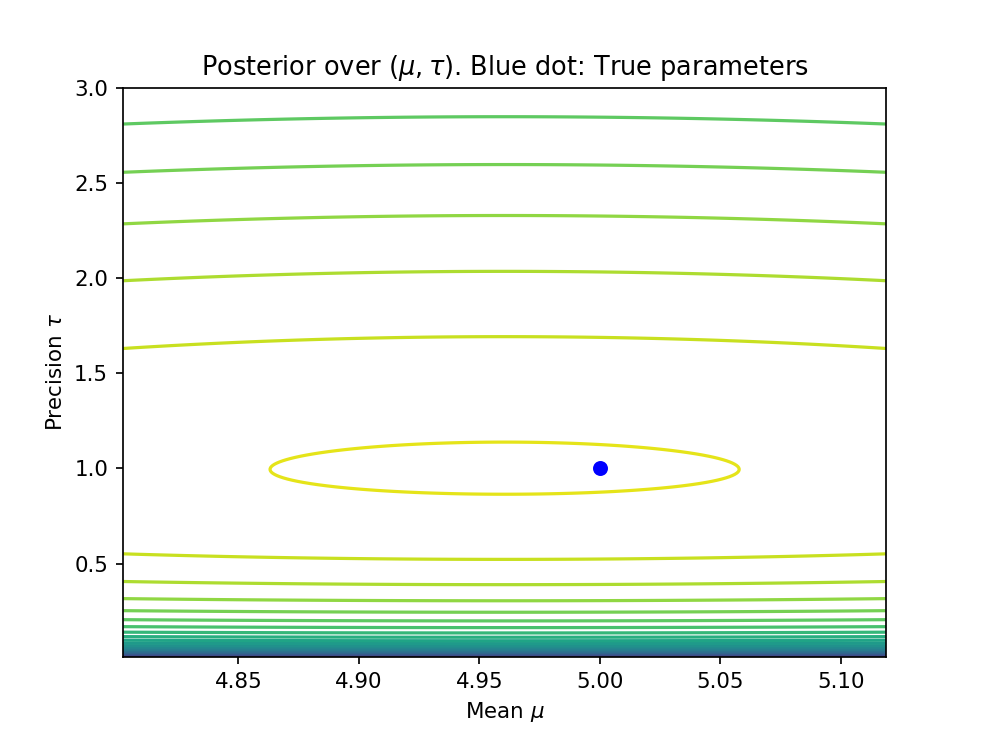

In [72]:
plot_posterior(q_mu, q_tau, q_alpha, q_beta, correct_mean, correct_precision)
plt.show()